# Initialisation


In [ ]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW4/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW4/empty text file created. You can also run !pwd command to confirm working directory.


In [ ]:
cd /content/drive/MyDrive/CIS680HW/HW4


/content


In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1pW-dS5VURWlYnyF8au7Gtt4gHC_yKKap/HW4'

In [ ]:
from rpn import *
from dataset import BuildDataLoader, BuildDataset
import torch.optim as optim

# Training


Loading the data set


In [ ]:
imgs_path = root_dir + 'CIS680HW' + '/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 8
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

Training the model

In [ ]:
rpn_net = RPNHead().to(device)
rpn_net2 = RPNHead().to(device)
optimizer = optim.SGD(rpn_net.parameters(),lr = 0.002,weight_decay=1.0e-4,momentum=0.90)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,35], gamma=0.20)
epochs = 40
batch_loss_list = []
batch_loss_c_list = []
batch_loss_r_list = []
batch_loss_list_test = []
batch_loss_c_list_test = []
batch_loss_r_list_test = []

for e in range(epochs):
    batch_loss = 0
    batch_loss_c = 0
    batch_loss_r = 0
    print("Epoch {}".format(e))
    #optimizer = optim.SGD(rpn_net.parameters(),lr = 0.001,weight_decay=1.0e-4,momentum=0.90)
    for i, batch in enumerate(train_loader):
        #pdb.set_trace()
        X = batch['images'].to(device)
        images = batch['images'][0,:,:,:]
        indexes = batch['indexes']
        boxes = batch['bboxes']
        gt, ground_coord = rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:]) 
        cls_out, reg_out = rpn_net.forward(X)
        loss, loss_c, loss_r = rpn_net.compute_loss(cls_out, reg_out, gt.to(device), ground_coord.to(device),effective_batch=batch_size*16)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss +=loss.cpu().item()
        batch_loss_c += loss_c.cpu().item()
        batch_loss_r += loss_r.cpu().item()
        
        if i % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
                  format(e, i * len(batch['images']), train_size,
                        100. * i / len(train_loader), loss.cpu().item()))

    print("Total Loss, Loss Class, Loss R: {} {}  {}".format(batch_loss,batch_loss_c,batch_loss_r))
    batch_loss_test = 0
    batch_loss_c_test = 0
    batch_loss_r_test = 0
    for i, batch in enumerate(test_loader):
      X = batch['images'].to(device)
      images = batch['images'][0,:,:,:]
      indexes = batch['indexes']
      boxes = batch['bboxes']
      rpn_net.eval()
      cls_out, reg_out = rpn_net.forward(X)
      gt, ground_coord = rpn_net2.create_batch_truth(boxes,indexes,images.shape[-2:]) 
      loss, loss_c, loss_r = rpn_net.compute_loss(cls_out, reg_out, gt.to(device), ground_coord.to(device),effective_batch=batch_size*8)
      batch_loss_test +=loss.cpu().item()
      batch_loss_c_test += loss_c.cpu().item()
      batch_loss_r_test += loss_r.cpu().item()

    batch_loss_list.append(batch_loss/len(train_loader))
    batch_loss_c_list.append(batch_loss_c/len(train_loader))
    batch_loss_r_list.append(batch_loss_r/len(train_loader))
    batch_loss_list_test.append(batch_loss_test/len(test_loader))
    batch_loss_c_list_test.append(batch_loss_c_test/len(test_loader))
    batch_loss_r_list_test.append(batch_loss_r_test/len(test_loader))
    scheduler.step()
torch.save(rpn_net.state_dict(), './model1_vs_bs8_efbs16')
np.save('batch_loss.npy', np.array(batch_loss_list))
np.save('batch_loss_c.npy', np.array(batch_loss_c_list))
np.save('batch_loss_r.npy', np.array(batch_loss_r_list))
np.save('batch_loss_test.npy', np.array(batch_loss_list_test))
np.save('batch_loss_c_test.npy', np.array(batch_loss_c_list_test))
np.save('batch_loss_r_test.npy', np.array(batch_loss_r_list_test))

In [ ]:
torch.save(rpn_net.state_dict(), './model3_HG.pth')

#Outputs for Report

**Outputs for Part 1(Datset visualisation), Part 3(Anchors), Part 5(Top 20 proposals) and Part 6 (Pre and Post NMS)**

In [ ]:
from rpn import *
from dataset import BuildDataLoader, BuildDataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb

def visualise_labels(images, labels, masks, bboxes ):
  img= images
  img = transforms.functional.normalize(img,
                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
  plt.figure()
  fig, ax = plt.subplots(1,1)
  img = img.permute(1,2,0)
  ax.imshow(img)
  annotations = ["vehicle", "person", "animal"]
  net_mask = None
  for c, l, m in zip(bboxes, labels, masks):
      cmap = ""
      col = ''
      if l == 1:
        cmap = "jet"
        col = 'b'
      elif l == 2:
        col = 'g'
        cmap = "ocean"
      else:
        col = 'r'
        cmap = "prism"
      
      rect=patches.Rectangle((c[0],c[1]),c[2]-c[0],c[3]-c[1],fill=False,color=col)
      ax.add_patch(rect)
      ax.annotate(annotations[l - 1], (c[0] + 40, c[1] - 50), color=col, weight='bold', 
              fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,edgecolor="white"))
      
      masked = np.ma.masked_where(m == 0, m)
      plt.imshow(masked, cmap, interpolation='none', alpha=0.7)
      
  plt.show()

def plot(ground_coord,gt,images,model,string='ground',i=0,anchors=None):
      
        fig,ax=plt.subplots(1,1)
        ax.imshow(images.permute(1,2,0))
        if gt.ndim == 1:
          find_cor=(gt==1).nonzero()
        else:
          find_cor=(gt==1).squeeze().nonzero()
        find_neg=(gt==0).squeeze().nonzero()
        for elem in find_cor:
            coord = torch.squeeze(ground_coord[elem,:].view(-1, 4))
            coord[0] = 0 if coord[0]<0 else coord[0]
            coord[1] = 0 if coord[1]<0 else coord[1]
            coord[2] = 800 if coord[0]>800 else coord[2]
            coord[3] = 1088 if coord[3]>1088 else coord[3]
            col='r'
            rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
            ax.add_patch(rect)
            if anchors is not None:
              anchor=anchors[elem,:]
              rect=patches.Rectangle((anchor[0],anchor[1]),anchor[2]-anchor[0],anchor[3]-anchor[1],fill=False,color='b')
              ax.add_patch(rect)
        plt.title(string)  
        plt.show()

        #plt.savefig("./results/"+string+"_truth_visualizations/images_{}".format(i))

In [ ]:

imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)


# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = iter(train_build_loader.loader())
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = iter(test_build_loader.loader())

model = RPNHead()
# push the randomized training data into the dataloader

model.load_state_dict(torch.load('./model1_vs_bs8_efbs16.pth'))
for i,batch in enumerate(train_loader,0):
    images=batch['images'][0,:,:,:]
    indexes=batch['indexes']
    boxes=batch['bboxes']
    print(boxes)
    print(batch['labels'])
    #pdb.set_trace()
    visualise_labels(images.clone(),batch['labels'][0].copy(),batch['masks'][0].clone(),boxes[0].copy())
    gt,ground_coord=model.create_batch_truth(boxes,indexes,images.shape[-2:])

    flatten_coord,flatten_gt,flatten_anchors=output_flattening(ground_coord,gt,model.get_anchors())

    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
    decoded_coord=output_decoding(flatten_coord,flatten_anchors)

    # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
    images = transforms.functional.normalize(images,
                                                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
    plot(decoded_coord,flatten_gt,images,model,string='ground',i=i,anchors=flatten_anchors)
    ## Forward
    model.eval()
    cls_out, reg_out = model.forward(batch['images'])
    flatten_coord_pred,flatten_clas_pred,flatten_anchors=output_flattening(reg_out.detach(),cls_out.detach(),model.get_anchors())
    
    # PointWise Accuracy
    #pdb.set_trace()
    prediction = flatten_clas_pred.clone()
    
    prediction[flatten_clas_pred>0.7] = 1
    prediction[flatten_clas_pred<0.7] = 0
    correct = torch.sum(prediction[flatten_gt==1])+ torch.sum(1 - prediction[flatten_gt==0])
    total = torch.sum(flatten_gt[flatten_gt==1])+torch.sum(1 - flatten_gt[flatten_gt==0])
    acc = correct/total
    print("Point Wise accuracy for Image {}".format(acc))
    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes for Part 5
    decoded_coord=output_decoding(flatten_coord_pred,flatten_anchors)

    sort_clas,indices = torch.sort(flatten_clas_pred,dim = 0, descending=True)

    top_proposals = indices[:20]
    top_proposals_clas = sort_clas[:20]

    #print(top_proposals_clas)
    #print(flatten_coord[top_proposals,:])
    top_proposals_clas[top_proposals_clas>0] = 1
    top_proposals_reg = decoded_coord[top_proposals,:]

    #print(top_proposals_reg)
    plot(top_proposals_reg,top_proposals_clas,images,model,string='top 20 prediction',i=i)

    # # part 6 inference results
    
    nms_clas_list, nms_prebox_list,pre_nms_clas_list, pre_nms_prebox_list = model.postprocess(cls_out,reg_out,IOU_thresh=0.6)
    nms_clas_list[0][nms_clas_list[0]>0] = 1
    pre_nms_clas_list[0][pre_nms_clas_list[0]>0] = 1
    
    # pdb.set_trace()
    plot(pre_nms_prebox_list[0].squeeze(),pre_nms_clas_list[0],images,model,string='predictionpreNMS',i=i)
    plot(nms_prebox_list[0],nms_clas_list[0],images,model,string='predictionpostNMS',i=i)
    plt.show()

    if(i>10):
        break

Output hidden; open in https://colab.research.google.com to view.

**Plots of the training and validation losses for total loss, regression loss and classification loss**

In [ ]:
batch_loss_list = np.load('./batch_loss.npy')
batch_loss_c_list=np.load('./batch_loss_c.npy')
batch_loss_r_list=np.load('./batch_loss_r.npy')
batch_loss_list_test=np.load('./batch_loss_test.npy')
batch_loss_c_list_test=np.load('./batch_loss_c_test.npy')
batch_loss_r_list_test=np.load('./batch_loss_r_test.npy')

In [ ]:
batch_loss_c_list

array([0.63961079, 0.64915168, 0.63416046, 0.62333478, 0.62270034,
       0.61058738, 0.59898187, 0.59580867, 0.60220031, 0.59899311,
       0.59178951, 0.59467685, 0.59220577, 0.5873157 , 0.58266433,
       0.58233505, 0.58644155, 0.57663063, 0.57907762, 0.57518387,
       0.57403448, 0.57598393, 0.57487332, 0.56766322, 0.56752114,
       0.56663962, 0.56044147, 0.55944217, 0.55885003, 0.55628519,
       0.56083173, 0.562981  , 0.56226379, 0.55479202, 0.5599171 ,
       0.55817032, 0.55880831, 0.55858285, 0.55688254, 0.55650199])

Text(0.5, 1.0, 'Validation  Regression Loss')

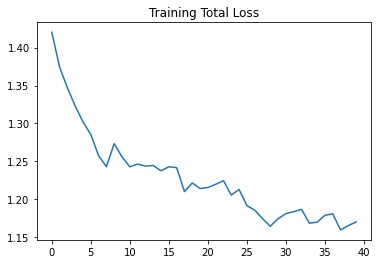

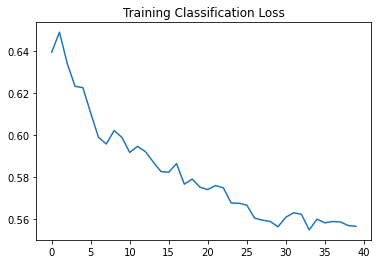

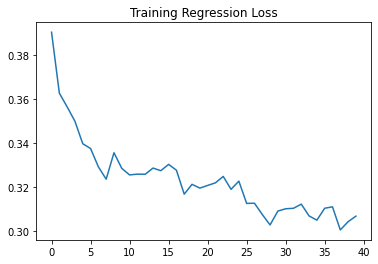

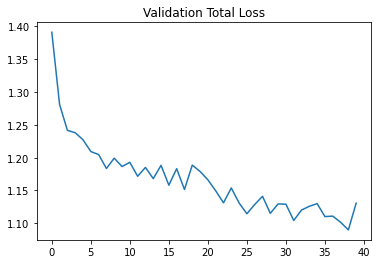

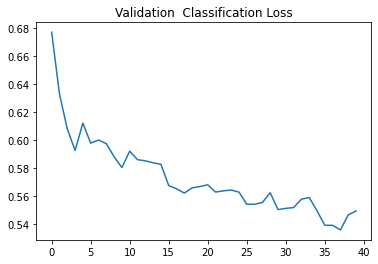

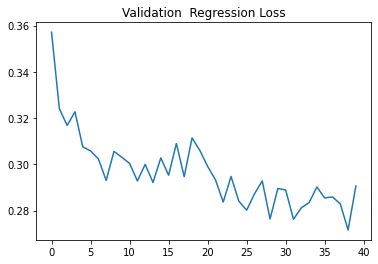

In [ ]:
plt.figure()
plt.plot(batch_loss_list)
plt.title('Training Total Loss')
plt.figure()
plt.plot(batch_loss_c_list)
plt.title('Training Classification Loss')
plt.figure()
plt.plot(batch_loss_r_list)
plt.title('Training Regression Loss')
plt.figure()
plt.plot(batch_loss_list_test)
plt.title('Validation Total Loss')
plt.figure()
plt.plot(batch_loss_c_list_test)
plt.title('Validation  Classification Loss')
plt.figure()
plt.plot(batch_loss_r_list_test)
plt.title('Validation  Regression Loss')